In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2 as cv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

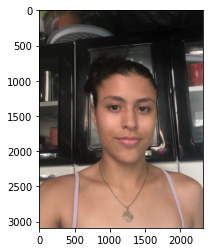

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('../input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_9.jpg')
imgplot = plt.imshow(img)

In [3]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

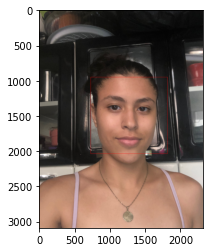

In [4]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
imgplot = plt.imshow(img)

In [5]:
images = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images,columns=['filenames'])

In [6]:
images['given_names'] = images.filenames.apply(lambda x: x[x.find('name')+5:x.find('/',x.find('name')+5)])

In [7]:
images["image_type"] = images.filenames.apply(lambda x: x[x.find('/',x.find('name')+5)+1:x.find('_',x.find('name')+5)])

In [8]:
images = images[2:].reset_index(drop=True)

In [9]:
images

,filenames,given_names,image_type
0,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
1,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
2,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
3,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
4,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
...,...,...,...
428,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
429,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
430,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
431,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie


In [10]:
def build_facematch_dataset(images):
    X1_dataset = []
    X2_dataset = []
    y1_dataset = []
    y2_dataset = []
    for i in range(len(images)-2):
        X1_dataset.append(images.filenames[i])
        X2_dataset.append(images.filenames[i+1])
        if images.given_names[i] == images.given_names[i+1]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[i+1] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
    for i in range(len(images)):
        first_sample = np.random.randint(0,len(images))
        second_sample = np.random.randint(0,len(images))
        X1_dataset.append(images.filenames[first_sample])
        X2_dataset.append(images.filenames[second_sample])
        if images.given_names[first_sample] == images.given_names[second_sample]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[second_sample] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
        
    return tf.data.Dataset.from_tensor_slices(({"input_1":X1_dataset,"input_2":X2_dataset},
                    {"facematch":y1_dataset,"liveness":y2_dataset}))

In [11]:
dataset = build_facematch_dataset(images)

2022-11-17 17:43:07.295031: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
def get_face_boxes(image):
    height, width = image.shape[0], image.shape[1]
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    face = face_cascade.detectMultiScale(image.numpy(), 1.3, 5)
    for (x,y,w,h) in face:
        return x/width, y/height, (x+w)/width, (y+h)/height

In [13]:
def process_path(img):
    CROP_SIZE = (90,90)
    raw = tf.io.read_file(img)
    image = tf.io.decode_jpeg(raw, channels=1)
    
    try:
        x1, y1, x2, y2 = get_face_boxes(image)
        image = tf.image.crop_and_resize(tf.expand_dims(image, axis=0),
                                          tf.constant([[y1, x1, y2, x2]], dtype=tf.float32),
                                          tf.constant([0]), CROP_SIZE)
        image = tf.squeeze(image, axis=0)
    except:
        image = tf.image.resize(image, CROP_SIZE)
    
    image = image/255
    return image

In [14]:
def parse_func(img):
    return tf.py_function(process_path,[img],tf.float32)

In [15]:
dataset = dataset.map(lambda images, labels: 
                      ({"input_1":parse_func(images["input_1"]),
                        "input_2":parse_func(images["input_2"])},
                       labels))

In [16]:
@tf.function
def rot90_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=1)
    img2 = tf.image.rot90(images["input_2"],k=1)
    return {"input_1":img1,"input_2":img2},labels

In [17]:
@tf.function
def rot180_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=2)
    img2 = tf.image.rot90(images["input_2"],k=2)
    return {"input_1":img1,"input_2":img2},labels

In [18]:
@tf.function
def rot270_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=3)
    img2 = tf.image.rot90(images["input_2"],k=3)
    return {"input_1":img1,"input_2":img2},labels

In [19]:
@tf.function
def left_right_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [20]:
@tf.function
def up_down_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [21]:
rot90_dataset = dataset.map(rot90_augment)
rot180_dataset = dataset.map(rot180_augment)
rot270_dataset = dataset.map(rot270_augment)
left_right_dataset = dataset.map(left_right_augment)
up_down_dataset = dataset.map(up_down_augment)

In [22]:
dataset = dataset.concatenate(rot90_dataset)
dataset = dataset.concatenate(rot180_dataset)
dataset = dataset.concatenate(rot270_dataset)
dataset = dataset.concatenate(left_right_dataset)
dataset = dataset.concatenate(up_down_dataset)

In [23]:
dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=5184>

In [24]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train, val, test = get_dataset_partitions_tf(dataset,dataset.__len__().numpy())

In [26]:
train = train.shuffle(100).batch(16)
val = val.shuffle(100).batch(16)
test = test.shuffle(100).batch(16)

In [27]:
from tensorflow import keras

In [28]:
def input_layers(image_size):
    model = keras.models.Sequential([
        keras.layers.Input(shape=image_size),
        keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(3),
        keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(3),
        keras.layers.Flatten()
    ])
    
    return model

In [29]:
base_model_A = input_layers((90, 90, 1))
base_model_B = input_layers((90, 90, 1))

In [30]:
concat = keras.layers.Concatenate()([base_model_A.output,base_model_B.output])
z = keras.layers.Dense(20,activation='relu')(concat)
bn = keras.layers.BatchNormalization()(z)
z = keras.layers.Dense(20,activation='relu')(bn)
output_A = keras.layers.Dense(1,activation='sigmoid',name='facematch')(z)
output_B = keras.layers.Dense(1,activation='sigmoid',name='liveness')(z)

In [31]:
model = keras.Model(inputs=[base_model_A.input,base_model_B.input],outputs=[output_A,output_B])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 90, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90, 90, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 90, 90, 32)   320         input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
optimizer = keras.optimizers.Nadam()
model.compile(loss={'facematch':"binary_crossentropy",'liveness': "binary_crossentropy"},
              optimizer=optimizer,metrics={'facematch': 'binary_accuracy', 'liveness': 'binary_accuracy'})

In [34]:
history = model.fit(train,epochs=2,validation_data=(val))

Epoch 1/2


2022-11-17 17:43:12.546786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-17 17:43:23.554348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 10 of 100
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid S

  7/260 [..............................] - ETA: 1:29:14 - loss: 1.5518 - facematch_loss: 0.7833 - liveness_loss: 0.7685 - facematch_binary_accuracy: 0.2679 - liveness_binary_accuracy: 0.5000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/260 [..............................] - ETA: 1:23:40 - loss: 1.5430 - facematch_loss: 0.7830 - liveness_loss: 0.7599 - facematch_binary_accuracy: 0.2656 - liveness_binary_accuracy: 0.5078

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/260 [>.............................] - ETA: 1:15:05 - loss: 1.4497 - facematch_loss: 0.7598 - liveness_loss: 0.6899 - facematch_binary_accuracy: 0.3042 - liveness_binary_accuracy: 0.6125

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/260 [>.............................] - ETA: 1:15:08 - loss: 1.4442 - facematch_loss: 0.7576 - liveness_loss: 0.6867 - facematch_binary_accuracy: 0.3125 - liveness_binary_accuracy: 0.6094

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/260 [=>............................] - ETA: 1:14:47 - loss: 1.4278 - facematch_loss: 0.7528 - liveness_loss: 0.6750 - facematch_binary_accuracy: 0.3160 - liveness_binary_accuracy: 0.6319

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/260 [=>............................] - ETA: 1:14:18 - loss: 1.4198 - facematch_loss: 0.7502 - liveness_loss: 0.6696 - facematch_binary_accuracy: 0.3289 - liveness_binary_accuracy: 0.6447

Invalid SOS parameters for sequential JPEG


 20/260 [=>............................] - ETA: 1:13:45 - loss: 1.4149 - facematch_loss: 0.7478 - liveness_loss: 0.6671 - facematch_binary_accuracy: 0.3313 - liveness_binary_accuracy: 0.6469

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/260 [=>............................] - ETA: 1:13:39 - loss: 1.4056 - facematch_loss: 0.7444 - liveness_loss: 0.6612 - facematch_binary_accuracy: 0.3512 - liveness_binary_accuracy: 0.6607

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/260 [=>............................] - ETA: 1:13:40 - loss: 1.4014 - facematch_loss: 0.7419 - liveness_loss: 0.6594 - facematch_binary_accuracy: 0.3551 - liveness_binary_accuracy: 0.6648

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/260 [=>............................] - ETA: 1:13:32 - loss: 1.3972 - facematch_loss: 0.7417 - liveness_loss: 0.6556 - facematch_binary_accuracy: 0.3533 - liveness_binary_accuracy: 0.6685

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/260 [=>............................] - ETA: 1:13:19 - loss: 1.3988 - facematch_loss: 0.7408 - liveness_loss: 0.6581 - facematch_binary_accuracy: 0.3542 - liveness_binary_accuracy: 0.6615

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/260 [=>............................] - ETA: 1:12:47 - loss: 1.3926 - facematch_loss: 0.7385 - liveness_loss: 0.6541 - facematch_binary_accuracy: 0.3650 - liveness_binary_accuracy: 0.6650

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/260 [==>...........................] - ETA: 1:12:23 - loss: 1.3882 - facematch_loss: 0.7381 - liveness_loss: 0.6501 - facematch_binary_accuracy: 0.3606 - liveness_binary_accuracy: 0.6683

Invalid SOS parameters for sequential JPEG


 27/260 [==>...........................] - ETA: 1:11:52 - loss: 1.3837 - facematch_loss: 0.7377 - liveness_loss: 0.6460 - facematch_binary_accuracy: 0.3565 - liveness_binary_accuracy: 0.6736

Invalid SOS parameters for sequential JPEG


 28/260 [==>...........................] - ETA: 1:11:14 - loss: 1.3810 - facematch_loss: 0.7367 - liveness_loss: 0.6442 - facematch_binary_accuracy: 0.3616 - liveness_binary_accuracy: 0.6741

Invalid SOS parameters for sequential JPEG


 29/260 [==>...........................] - ETA: 1:11:20 - loss: 1.3757 - facematch_loss: 0.7353 - liveness_loss: 0.6405 - facematch_binary_accuracy: 0.3621 - liveness_binary_accuracy: 0.6789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/260 [==>...........................] - ETA: 1:10:53 - loss: 1.3764 - facematch_loss: 0.7350 - liveness_loss: 0.6414 - facematch_binary_accuracy: 0.3583 - liveness_binary_accuracy: 0.6812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/260 [==>...........................] - ETA: 1:10:44 - loss: 1.3696 - facematch_loss: 0.7331 - liveness_loss: 0.6365 - facematch_binary_accuracy: 0.3649 - liveness_binary_accuracy: 0.6895

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/260 [==>...........................] - ETA: 1:10:11 - loss: 1.3661 - facematch_loss: 0.7318 - liveness_loss: 0.6343 - facematch_binary_accuracy: 0.3730 - liveness_binary_accuracy: 0.6914

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/260 [==>...........................] - ETA: 1:09:38 - loss: 1.3613 - facematch_loss: 0.7306 - liveness_loss: 0.6308 - facematch_binary_accuracy: 0.3788 - liveness_binary_accuracy: 0.6989

Invalid SOS parameters for sequential JPEG


 34/260 [==>...........................] - ETA: 1:09:30 - loss: 1.3596 - facematch_loss: 0.7289 - liveness_loss: 0.6308 - facematch_binary_accuracy: 0.3824 - liveness_binary_accuracy: 0.6985

Invalid SOS parameters for sequential JPEG


 35/260 [===>..........................] - ETA: 1:09:41 - loss: 1.3557 - facematch_loss: 0.7270 - liveness_loss: 0.6287 - facematch_binary_accuracy: 0.3875 - liveness_binary_accuracy: 0.7018

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/260 [===>..........................] - ETA: 1:09:18 - loss: 1.3558 - facematch_loss: 0.7266 - liveness_loss: 0.6292 - facematch_binary_accuracy: 0.3941 - liveness_binary_accuracy: 0.6997

Invalid SOS parameters for sequential JPEG


 37/260 [===>..........................] - ETA: 1:08:52 - loss: 1.3525 - facematch_loss: 0.7253 - liveness_loss: 0.6272 - facematch_binary_accuracy: 0.3970 - liveness_binary_accuracy: 0.7044

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/260 [===>..........................] - ETA: 1:08:56 - loss: 1.3356 - facematch_loss: 0.7194 - liveness_loss: 0.6162 - facematch_binary_accuracy: 0.4172 - liveness_binary_accuracy: 0.7188

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/260 [===>..........................] - ETA: 1:08:41 - loss: 1.3294 - facematch_loss: 0.7174 - liveness_loss: 0.6119 - facematch_binary_accuracy: 0.4238 - liveness_binary_accuracy: 0.7241

Invalid SOS parameters for sequential JPEG


 42/260 [===>..........................] - ETA: 1:08:36 - loss: 1.3231 - facematch_loss: 0.7154 - liveness_loss: 0.6077 - facematch_binary_accuracy: 0.4315 - liveness_binary_accuracy: 0.7307

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/260 [===>..........................] - ETA: 1:07:44 - loss: 1.3204 - facematch_loss: 0.7137 - liveness_loss: 0.6066 - facematch_binary_accuracy: 0.4360 - liveness_binary_accuracy: 0.7355

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/260 [======>.......................] - ETA: 1:04:04 - loss: 1.2813 - facematch_loss: 0.7081 - liveness_loss: 0.5732 - facematch_binary_accuracy: 0.4641 - liveness_binary_accuracy: 0.7674

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/260 [======>.......................] - ETA: 1:03:20 - loss: 1.2816 - facematch_loss: 0.7087 - liveness_loss: 0.5728 - facematch_binary_accuracy: 0.4617 - liveness_binary_accuracy: 0.7681

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 69/260 [======>.......................] - ETA: 1:00:10 - loss: 1.2699 - facematch_loss: 0.7103 - liveness_loss: 0.5597 - facematch_binary_accuracy: 0.4601 - liveness_binary_accuracy: 0.7835

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/260 [=======>......................] - ETA: 59:54 - loss: 1.2702 - facematch_loss: 0.7106 - liveness_loss: 0.5596 - facematch_binary_accuracy: 0.4607 - liveness_binary_accuracy: 0.7830  

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/260 [=======>......................] - ETA: 59:18 - loss: 1.2677 - facematch_loss: 0.7110 - liveness_loss: 0.5567 - facematch_binary_accuracy: 0.4575 - liveness_binary_accuracy: 0.7830

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/260 [=======>......................] - ETA: 58:57 - loss: 1.2650 - facematch_loss: 0.7106 - liveness_loss: 0.5544 - facematch_binary_accuracy: 0.4589 - liveness_binary_accuracy: 0.7842

Invalid SOS parameters for sequential JPEG


 74/260 [=======>......................] - ETA: 58:35 - loss: 1.2656 - facematch_loss: 0.7103 - liveness_loss: 0.5553 - facematch_binary_accuracy: 0.4595 - liveness_binary_accuracy: 0.7855

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/260 [=======>......................] - ETA: 58:18 - loss: 1.2647 - facematch_loss: 0.7107 - liveness_loss: 0.5539 - facematch_binary_accuracy: 0.4575 - liveness_binary_accuracy: 0.7867

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/260 [=======>......................] - ETA: 58:03 - loss: 1.2625 - facematch_loss: 0.7100 - liveness_loss: 0.5525 - facematch_binary_accuracy: 0.4613 - liveness_binary_accuracy: 0.7887

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/260 [=======>......................] - ETA: 57:46 - loss: 1.2611 - facematch_loss: 0.7099 - liveness_loss: 0.5512 - facematch_binary_accuracy: 0.4602 - liveness_binary_accuracy: 0.7906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/260 [========>.....................] - ETA: 57:29 - loss: 1.2601 - facematch_loss: 0.7095 - liveness_loss: 0.5506 - facematch_binary_accuracy: 0.4623 - liveness_binary_accuracy: 0.7909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/260 [========>.....................] - ETA: 57:06 - loss: 1.2585 - facematch_loss: 0.7090 - liveness_loss: 0.5496 - facematch_binary_accuracy: 0.4644 - liveness_binary_accuracy: 0.7919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/260 [========>.....................] - ETA: 56:46 - loss: 1.2593 - facematch_loss: 0.7093 - liveness_loss: 0.5500 - facematch_binary_accuracy: 0.4664 - liveness_binary_accuracy: 0.7922

Invalid SOS parameters for sequential JPEG


 81/260 [========>.....................] - ETA: 56:23 - loss: 1.2593 - facematch_loss: 0.7096 - liveness_loss: 0.5497 - facematch_binary_accuracy: 0.4653 - liveness_binary_accuracy: 0.7924

Invalid SOS parameters for sequential JPEG


 82/260 [========>.....................] - ETA: 55:58 - loss: 1.2579 - facematch_loss: 0.7093 - liveness_loss: 0.5487 - facematch_binary_accuracy: 0.4680 - liveness_binary_accuracy: 0.7934

Invalid SOS parameters for sequential JPEG


 83/260 [========>.....................] - ETA: 55:45 - loss: 1.2577 - facematch_loss: 0.7095 - liveness_loss: 0.5483 - facematch_binary_accuracy: 0.4669 - liveness_binary_accuracy: 0.7944

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 84/260 [========>.....................] - ETA: 55:24 - loss: 1.2569 - facematch_loss: 0.7098 - liveness_loss: 0.5470 - facematch_binary_accuracy: 0.4650 - liveness_binary_accuracy: 0.7961

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/260 [========>.....................] - ETA: 55:06 - loss: 1.2579 - facematch_loss: 0.7101 - liveness_loss: 0.5479 - facematch_binary_accuracy: 0.4640 - liveness_binary_accuracy: 0.7956

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/260 [========>.....................] - ETA: 54:43 - loss: 1.2577 - facematch_loss: 0.7103 - liveness_loss: 0.5474 - facematch_binary_accuracy: 0.4629 - liveness_binary_accuracy: 0.7958

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/260 [=========>....................] - ETA: 54:20 - loss: 1.2566 - facematch_loss: 0.7102 - liveness_loss: 0.5464 - facematch_binary_accuracy: 0.4619 - liveness_binary_accuracy: 0.7967

Invalid SOS parameters for sequential JPEG


 88/260 [=========>....................] - ETA: 54:03 - loss: 1.2562 - facematch_loss: 0.7104 - liveness_loss: 0.5457 - facematch_binary_accuracy: 0.4616 - liveness_binary_accuracy: 0.7969

Invalid SOS parameters for sequential JPEG


 89/260 [=========>....................] - ETA: 53:53 - loss: 1.2552 - facematch_loss: 0.7105 - liveness_loss: 0.5448 - facematch_binary_accuracy: 0.4621 - liveness_binary_accuracy: 0.7978

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/260 [=========>....................] - ETA: 53:32 - loss: 1.2550 - facematch_loss: 0.7103 - liveness_loss: 0.5447 - facematch_binary_accuracy: 0.4632 - liveness_binary_accuracy: 0.7979

Invalid SOS parameters for sequential JPEG


 91/260 [=========>....................] - ETA: 53:11 - loss: 1.2537 - facematch_loss: 0.7103 - liveness_loss: 0.5434 - facematch_binary_accuracy: 0.4629 - liveness_binary_accuracy: 0.7995

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/260 [=========>....................] - ETA: 52:32 - loss: 1.2495 - facematch_loss: 0.7102 - liveness_loss: 0.5393 - facematch_binary_accuracy: 0.4614 - liveness_binary_accuracy: 0.8039

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/260 [=========>....................] - ETA: 52:14 - loss: 1.2478 - facematch_loss: 0.7100 - liveness_loss: 0.5378 - facematch_binary_accuracy: 0.4618 - liveness_binary_accuracy: 0.8053

Invalid SOS parameters for sequential JPEG


 96/260 [==========>...................] - ETA: 52:00 - loss: 1.2459 - facematch_loss: 0.7098 - liveness_loss: 0.5360 - facematch_binary_accuracy: 0.4635 - liveness_binary_accuracy: 0.8066

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/260 [==========>...................] - ETA: 51:31 - loss: 1.2457 - facematch_loss: 0.7096 - liveness_loss: 0.5361 - facematch_binary_accuracy: 0.4659 - liveness_binary_accuracy: 0.8061

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/260 [============>.................] - ETA: 46:29 - loss: 1.2293 - facematch_loss: 0.7073 - liveness_loss: 0.5219 - facematch_binary_accuracy: 0.4745 - liveness_binary_accuracy: 0.8174

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


116/260 [============>.................] - ETA: 46:00 - loss: 1.2289 - facematch_loss: 0.7073 - liveness_loss: 0.5216 - facematch_binary_accuracy: 0.4741 - liveness_binary_accuracy: 0.8179

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/260 [=============>................] - ETA: 43:23 - loss: 1.2266 - facematch_loss: 0.7073 - liveness_loss: 0.5193 - facematch_binary_accuracy: 0.4771 - liveness_binary_accuracy: 0.8181

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/260 [=============>................] - ETA: 43:05 - loss: 1.2249 - facematch_loss: 0.7074 - liveness_loss: 0.5175 - facematch_binary_accuracy: 0.4778 - liveness_binary_accuracy: 0.8196

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/260 [=============>................] - ETA: 42:27 - loss: 1.2228 - facematch_loss: 0.7073 - liveness_loss: 0.5155 - facematch_binary_accuracy: 0.4772 - liveness_binary_accuracy: 0.8209

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/260 [=============>................] - ETA: 42:07 - loss: 1.2217 - facematch_loss: 0.7070 - liveness_loss: 0.5148 - facematch_binary_accuracy: 0.4793 - liveness_binary_accuracy: 0.8209

Invalid SOS parameters for sequential JPEG


128/260 [=============>................] - ETA: 41:47 - loss: 1.2206 - facematch_loss: 0.7067 - liveness_loss: 0.5139 - facematch_binary_accuracy: 0.4810 - liveness_binary_accuracy: 0.8213

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/260 [=============>................] - ETA: 41:28 - loss: 1.2192 - facematch_loss: 0.7068 - liveness_loss: 0.5123 - facematch_binary_accuracy: 0.4801 - liveness_binary_accuracy: 0.8222

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/260 [==============>...............] - ETA: 41:11 - loss: 1.2171 - facematch_loss: 0.7068 - liveness_loss: 0.5104 - facematch_binary_accuracy: 0.4803 - liveness_binary_accuracy: 0.8236

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/260 [==============>...............] - ETA: 40:52 - loss: 1.2165 - facematch_loss: 0.7063 - liveness_loss: 0.5102 - facematch_binary_accuracy: 0.4828 - liveness_binary_accuracy: 0.8240

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/260 [==============>...............] - ETA: 40:34 - loss: 1.2161 - facematch_loss: 0.7062 - liveness_loss: 0.5099 - facematch_binary_accuracy: 0.4844 - liveness_binary_accuracy: 0.8239

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/260 [==============>...............] - ETA: 40:13 - loss: 1.2159 - facematch_loss: 0.7058 - liveness_loss: 0.5101 - facematch_binary_accuracy: 0.4859 - liveness_binary_accuracy: 0.8233

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/260 [==============>...............] - ETA: 39:54 - loss: 1.2146 - facematch_loss: 0.7059 - liveness_loss: 0.5087 - facematch_binary_accuracy: 0.4846 - liveness_binary_accuracy: 0.8242

Invalid SOS parameters for sequential JPEG


135/260 [==============>...............] - ETA: 39:33 - loss: 1.2139 - facematch_loss: 0.7063 - liveness_loss: 0.5076 - facematch_binary_accuracy: 0.4838 - liveness_binary_accuracy: 0.8245

Invalid SOS parameters for sequential JPEG


136/260 [==============>...............] - ETA: 39:11 - loss: 1.2120 - facematch_loss: 0.7063 - liveness_loss: 0.5057 - facematch_binary_accuracy: 0.4821 - liveness_binary_accuracy: 0.8258

Invalid SOS parameters for sequential JPEG


137/260 [==============>...............] - ETA: 38:54 - loss: 1.2118 - facematch_loss: 0.7064 - liveness_loss: 0.5055 - facematch_binary_accuracy: 0.4813 - liveness_binary_accuracy: 0.8262

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/260 [==============>...............] - ETA: 38:34 - loss: 1.2115 - facematch_loss: 0.7065 - liveness_loss: 0.5051 - facematch_binary_accuracy: 0.4796 - liveness_binary_accuracy: 0.8261

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/260 [===============>..............] - ETA: 38:16 - loss: 1.2121 - facematch_loss: 0.7066 - liveness_loss: 0.5055 - facematch_binary_accuracy: 0.4775 - liveness_binary_accuracy: 0.8255

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/260 [===============>..............] - ETA: 37:55 - loss: 1.2143 - facematch_loss: 0.7065 - liveness_loss: 0.5077 - facematch_binary_accuracy: 0.4777 - liveness_binary_accuracy: 0.8241

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/260 [===============>..............] - ETA: 37:34 - loss: 1.2127 - facematch_loss: 0.7065 - liveness_loss: 0.5062 - facematch_binary_accuracy: 0.4787 - liveness_binary_accuracy: 0.8249

Invalid SOS parameters for sequential JPEG


142/260 [===============>..............] - ETA: 37:16 - loss: 1.2138 - facematch_loss: 0.7063 - liveness_loss: 0.5074 - facematch_binary_accuracy: 0.4789 - liveness_binary_accuracy: 0.8239

Invalid SOS parameters for sequential JPEG


143/260 [===============>..............] - ETA: 37:00 - loss: 1.2121 - facematch_loss: 0.7064 - liveness_loss: 0.5057 - facematch_binary_accuracy: 0.4777 - liveness_binary_accuracy: 0.8252

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/260 [===============>..............] - ETA: 36:41 - loss: 1.2119 - facematch_loss: 0.7064 - liveness_loss: 0.5055 - facematch_binary_accuracy: 0.4774 - liveness_binary_accuracy: 0.8247

Invalid SOS parameters for sequential JPEG


145/260 [===============>..............] - ETA: 36:20 - loss: 1.2109 - facematch_loss: 0.7064 - liveness_loss: 0.5045 - facematch_binary_accuracy: 0.4772 - liveness_binary_accuracy: 0.8254

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/260 [================>.............] - ETA: 35:31 - loss: 1.2072 - facematch_loss: 0.7057 - liveness_loss: 0.5015 - facematch_binary_accuracy: 0.4776 - liveness_binary_accuracy: 0.8269

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/260 [================>.............] - ETA: 35:12 - loss: 1.2062 - facematch_loss: 0.7053 - liveness_loss: 0.5009 - facematch_binary_accuracy: 0.4794 - liveness_binary_accuracy: 0.8272

Invalid SOS parameters for sequential JPEG


150/260 [================>.............] - ETA: 34:55 - loss: 1.2055 - facematch_loss: 0.7053 - liveness_loss: 0.5002 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 0.8275

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/260 [================>.............] - ETA: 34:31 - loss: 1.2048 - facematch_loss: 0.7049 - liveness_loss: 0.4999 - facematch_binary_accuracy: 0.4801 - liveness_binary_accuracy: 0.8274

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/260 [==================>...........] - ETA: 29:06 - loss: 1.1880 - facematch_loss: 0.7043 - liveness_loss: 0.4837 - facematch_binary_accuracy: 0.4848 - liveness_binary_accuracy: 0.8347

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/260 [==================>...........] - ETA: 28:43 - loss: 1.1865 - facematch_loss: 0.7044 - liveness_loss: 0.4821 - facematch_binary_accuracy: 0.4831 - liveness_binary_accuracy: 0.8357

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/260 [===================>..........] - ETA: 26:19 - loss: 1.1851 - facematch_loss: 0.7053 - liveness_loss: 0.4797 - facematch_binary_accuracy: 0.4746 - liveness_binary_accuracy: 0.8351

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/260 [===================>..........] - ETA: 26:01 - loss: 1.1843 - facematch_loss: 0.7053 - liveness_loss: 0.4789 - facematch_binary_accuracy: 0.4747 - liveness_binary_accuracy: 0.8353

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


180/260 [===================>..........] - ETA: 25:23 - loss: 1.1843 - facematch_loss: 0.7051 - liveness_loss: 0.4792 - facematch_binary_accuracy: 0.4764 - liveness_binary_accuracy: 0.8347

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/260 [===================>..........] - ETA: 25:03 - loss: 1.1826 - facematch_loss: 0.7049 - liveness_loss: 0.4776 - facematch_binary_accuracy: 0.4779 - liveness_binary_accuracy: 0.8356

Invalid SOS parameters for sequential JPEG


182/260 [====================>.........] - ETA: 24:44 - loss: 1.1812 - facematch_loss: 0.7049 - liveness_loss: 0.4763 - facematch_binary_accuracy: 0.4777 - liveness_binary_accuracy: 0.8362

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/260 [====================>.........] - ETA: 24:25 - loss: 1.1804 - facematch_loss: 0.7047 - liveness_loss: 0.4757 - facematch_binary_accuracy: 0.4785 - liveness_binary_accuracy: 0.8364

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/260 [====================>.........] - ETA: 24:06 - loss: 1.1794 - facematch_loss: 0.7046 - liveness_loss: 0.4748 - facematch_binary_accuracy: 0.4786 - liveness_binary_accuracy: 0.8370

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/260 [====================>.........] - ETA: 23:48 - loss: 1.1781 - facematch_loss: 0.7045 - liveness_loss: 0.4736 - facematch_binary_accuracy: 0.4794 - liveness_binary_accuracy: 0.8375

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/260 [====================>.........] - ETA: 23:29 - loss: 1.1804 - facematch_loss: 0.7045 - liveness_loss: 0.4759 - facematch_binary_accuracy: 0.4788 - liveness_binary_accuracy: 0.8364

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/260 [====================>.........] - ETA: 23:09 - loss: 1.1803 - facematch_loss: 0.7045 - liveness_loss: 0.4757 - facematch_binary_accuracy: 0.4796 - liveness_binary_accuracy: 0.8362

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/260 [====================>.........] - ETA: 22:49 - loss: 1.1786 - facematch_loss: 0.7044 - liveness_loss: 0.4742 - facematch_binary_accuracy: 0.4804 - liveness_binary_accuracy: 0.8371

Invalid SOS parameters for sequential JPEG


189/260 [====================>.........] - ETA: 22:30 - loss: 1.1780 - facematch_loss: 0.7045 - liveness_loss: 0.4735 - facematch_binary_accuracy: 0.4802 - liveness_binary_accuracy: 0.8373

Invalid SOS parameters for sequential JPEG


190/260 [====================>.........] - ETA: 22:10 - loss: 1.1794 - facematch_loss: 0.7046 - liveness_loss: 0.4749 - facematch_binary_accuracy: 0.4793 - liveness_binary_accuracy: 0.8365

Invalid SOS parameters for sequential JPEG


191/260 [=====================>........] - ETA: 21:52 - loss: 1.1787 - facematch_loss: 0.7045 - liveness_loss: 0.4742 - facematch_binary_accuracy: 0.4791 - liveness_binary_accuracy: 0.8367

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/260 [=====================>........] - ETA: 21:32 - loss: 1.1782 - facematch_loss: 0.7046 - liveness_loss: 0.4736 - facematch_binary_accuracy: 0.4779 - liveness_binary_accuracy: 0.8366

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/260 [=====================>........] - ETA: 21:13 - loss: 1.1772 - facematch_loss: 0.7046 - liveness_loss: 0.4726 - facematch_binary_accuracy: 0.4790 - liveness_binary_accuracy: 0.8371

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/260 [=====================>........] - ETA: 20:53 - loss: 1.1763 - facematch_loss: 0.7045 - liveness_loss: 0.4717 - facematch_binary_accuracy: 0.4784 - liveness_binary_accuracy: 0.8373

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/260 [=====================>........] - ETA: 20:34 - loss: 1.1751 - facematch_loss: 0.7045 - liveness_loss: 0.4706 - facematch_binary_accuracy: 0.4776 - liveness_binary_accuracy: 0.8378

Invalid SOS parameters for sequential JPEG


196/260 [=====================>........] - ETA: 20:15 - loss: 1.1739 - facematch_loss: 0.7045 - liveness_loss: 0.4694 - facematch_binary_accuracy: 0.4786 - liveness_binary_accuracy: 0.8383

Invalid SOS parameters for sequential JPEG


197/260 [=====================>........] - ETA: 19:57 - loss: 1.1735 - facematch_loss: 0.7044 - liveness_loss: 0.4691 - facematch_binary_accuracy: 0.4791 - liveness_binary_accuracy: 0.8382

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/260 [=====================>........] - ETA: 19:38 - loss: 1.1727 - facematch_loss: 0.7043 - liveness_loss: 0.4684 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 0.8384

Invalid SOS parameters for sequential JPEG


199/260 [=====================>........] - ETA: 19:18 - loss: 1.1723 - facematch_loss: 0.7041 - liveness_loss: 0.4682 - facematch_binary_accuracy: 0.4805 - liveness_binary_accuracy: 0.8383

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/260 [======================>.......] - ETA: 18:24 - loss: 1.1708 - facematch_loss: 0.7039 - liveness_loss: 0.4668 - facematch_binary_accuracy: 0.4805 - liveness_binary_accuracy: 0.8385

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/260 [======================>.......] - ETA: 18:05 - loss: 1.1695 - facematch_loss: 0.7038 - liveness_loss: 0.4656 - facematch_binary_accuracy: 0.4809 - liveness_binary_accuracy: 0.8390

Invalid SOS parameters for sequential JPEG


204/260 [======================>.......] - ETA: 17:47 - loss: 1.1687 - facematch_loss: 0.7036 - liveness_loss: 0.4651 - facematch_binary_accuracy: 0.4819 - liveness_binary_accuracy: 0.8388

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/260 [======================>.......] - ETA: 17:26 - loss: 1.1678 - facematch_loss: 0.7033 - liveness_loss: 0.4645 - facematch_binary_accuracy: 0.4832 - liveness_binary_accuracy: 0.8390

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/260 [========================>.....] - ETA: 11:49 - loss: 1.1580 - facematch_loss: 0.7034 - liveness_loss: 0.4546 - facematch_binary_accuracy: 0.4837 - liveness_binary_accuracy: 0.8436

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/260 [========================>.....] - ETA: 11:29 - loss: 1.1589 - facematch_loss: 0.7034 - liveness_loss: 0.4555 - facematch_binary_accuracy: 0.4835 - liveness_binary_accuracy: 0.8429

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/260 [=========================>....] - ETA: 9:13 - loss: 1.1553 - facematch_loss: 0.7026 - liveness_loss: 0.4526 - facematch_binary_accuracy: 0.4865 - liveness_binary_accuracy: 0.8442

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/260 [=========================>....] - ETA: 8:54 - loss: 1.1547 - facematch_loss: 0.7025 - liveness_loss: 0.4522 - facematch_binary_accuracy: 0.4871 - liveness_binary_accuracy: 0.8440

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/260 [==========================>...] - ETA: 8:16 - loss: 1.1536 - facematch_loss: 0.7022 - liveness_loss: 0.4514 - facematch_binary_accuracy: 0.4885 - liveness_binary_accuracy: 0.8446

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


235/260 [==========================>...] - ETA: 7:56 - loss: 1.1525 - facematch_loss: 0.7021 - liveness_loss: 0.4503 - facematch_binary_accuracy: 0.4888 - liveness_binary_accuracy: 0.8452

Invalid SOS parameters for sequential JPEG


236/260 [==========================>...] - ETA: 7:37 - loss: 1.1522 - facematch_loss: 0.7019 - liveness_loss: 0.4503 - facematch_binary_accuracy: 0.4897 - liveness_binary_accuracy: 0.8451

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/260 [==========================>...] - ETA: 7:18 - loss: 1.1519 - facematch_loss: 0.7018 - liveness_loss: 0.4501 - facematch_binary_accuracy: 0.4902 - liveness_binary_accuracy: 0.8452

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/260 [==========================>...] - ETA: 6:59 - loss: 1.1520 - facematch_loss: 0.7016 - liveness_loss: 0.4504 - facematch_binary_accuracy: 0.4908 - liveness_binary_accuracy: 0.8448

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


239/260 [==========================>...] - ETA: 6:40 - loss: 1.1511 - facematch_loss: 0.7013 - liveness_loss: 0.4498 - facematch_binary_accuracy: 0.4919 - liveness_binary_accuracy: 0.8452

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/260 [==========================>...] - ETA: 6:21 - loss: 1.1502 - facematch_loss: 0.7013 - liveness_loss: 0.4489 - facematch_binary_accuracy: 0.4919 - liveness_binary_accuracy: 0.8456

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


241/260 [==========================>...] - ETA: 6:02 - loss: 1.1499 - facematch_loss: 0.7012 - liveness_loss: 0.4487 - facematch_binary_accuracy: 0.4922 - liveness_binary_accuracy: 0.8457

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/260 [==========================>...] - ETA: 5:43 - loss: 1.1494 - facematch_loss: 0.7010 - liveness_loss: 0.4484 - facematch_binary_accuracy: 0.4925 - liveness_binary_accuracy: 0.8458

Invalid SOS parameters for sequential JPEG


243/260 [===========================>..] - ETA: 5:24 - loss: 1.1498 - facematch_loss: 0.7008 - liveness_loss: 0.4490 - facematch_binary_accuracy: 0.4936 - liveness_binary_accuracy: 0.8454

Invalid SOS parameters for sequential JPEG


244/260 [===========================>..] - ETA: 5:04 - loss: 1.1494 - facematch_loss: 0.7011 - liveness_loss: 0.4483 - facematch_binary_accuracy: 0.4926 - liveness_binary_accuracy: 0.8455

Invalid SOS parameters for sequential JPEG


245/260 [===========================>..] - ETA: 4:46 - loss: 1.1490 - facematch_loss: 0.7011 - liveness_loss: 0.4478 - facematch_binary_accuracy: 0.4923 - liveness_binary_accuracy: 0.8457

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/260 [===========================>..] - ETA: 4:26 - loss: 1.1501 - facematch_loss: 0.7013 - liveness_loss: 0.4488 - facematch_binary_accuracy: 0.4921 - liveness_binary_accuracy: 0.8450

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/260 [===========================>..] - ETA: 4:07 - loss: 1.1498 - facematch_loss: 0.7016 - liveness_loss: 0.4482 - facematch_binary_accuracy: 0.4909 - liveness_binary_accuracy: 0.8451

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/260 [===========================>..] - ETA: 3:48 - loss: 1.1498 - facematch_loss: 0.7017 - liveness_loss: 0.4481 - facematch_binary_accuracy: 0.4902 - liveness_binary_accuracy: 0.8450

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/260 [===========================>..] - ETA: 3:29 - loss: 1.1500 - facematch_loss: 0.7019 - liveness_loss: 0.4481 - facematch_binary_accuracy: 0.4897 - liveness_binary_accuracy: 0.8451

Invalid SOS parameters for sequential JPEG


250/260 [===========================>..] - ETA: 3:10 - loss: 1.1505 - facematch_loss: 0.7020 - liveness_loss: 0.4485 - facematch_binary_accuracy: 0.4893 - liveness_binary_accuracy: 0.8447

Invalid SOS parameters for sequential JPEG


251/260 [===========================>..] - ETA: 2:51 - loss: 1.1496 - facematch_loss: 0.7020 - liveness_loss: 0.4476 - facematch_binary_accuracy: 0.4888 - liveness_binary_accuracy: 0.8451

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/260 [============================>.] - ETA: 2:32 - loss: 1.1490 - facematch_loss: 0.7021 - liveness_loss: 0.4469 - facematch_binary_accuracy: 0.4881 - liveness_binary_accuracy: 0.8455

Invalid SOS parameters for sequential JPEG


260/260 [==============================] - ETA: 0s - loss: 1.1453 - facematch_loss: 0.7021 - liveness_loss: 0.4432 - facematch_binary_accuracy: 0.4869 - liveness_binary_accuracy: 0.8464 

2022-11-17 19:08:06.335204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11 of 100
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2022-11-17 19:08:15.866855: I tensor

260/260 [==============================] - 10868s 41s/step - loss: 1.1453 - facematch_loss: 0.7021 - liveness_loss: 0.4432 - facematch_binary_accuracy: 0.4869 - liveness_binary_accuracy: 0.8464 - val_loss: 2.0685 - val_facematch_loss: 0.7703 - val_liveness_loss: 1.2983 - val_facematch_binary_accuracy: 0.3900 - val_liveness_binary_accuracy: 0.2645
Epoch 2/2


2022-11-17 20:44:46.137200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11 of 100
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2022-11-17 20:44:55.832613: I tensor

  7/260 [..............................] - ETA: 1:26:16 - loss: 1.1238 - facematch_loss: 0.7213 - liveness_loss: 0.4025 - facematch_binary_accuracy: 0.4464 - liveness_binary_accuracy: 0.8393

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/260 [..............................] - ETA: 1:20:40 - loss: 1.1203 - facematch_loss: 0.7181 - liveness_loss: 0.4022 - facematch_binary_accuracy: 0.4531 - liveness_binary_accuracy: 0.8281

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/260 [>.............................] - ETA: 1:12:53 - loss: 1.0328 - facematch_loss: 0.6998 - liveness_loss: 0.3330 - facematch_binary_accuracy: 0.5125 - liveness_binary_accuracy: 0.8875

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/260 [>.............................] - ETA: 1:13:23 - loss: 1.0298 - facematch_loss: 0.6984 - liveness_loss: 0.3314 - facematch_binary_accuracy: 0.5195 - liveness_binary_accuracy: 0.8906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/260 [=>............................] - ETA: 1:13:34 - loss: 1.0378 - facematch_loss: 0.6937 - liveness_loss: 0.3441 - facematch_binary_accuracy: 0.5347 - liveness_binary_accuracy: 0.8819

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/260 [=>............................] - ETA: 1:13:19 - loss: 1.0453 - facematch_loss: 0.6910 - liveness_loss: 0.3542 - facematch_binary_accuracy: 0.5428 - liveness_binary_accuracy: 0.8750

Invalid SOS parameters for sequential JPEG


 20/260 [=>............................] - ETA: 1:13:00 - loss: 1.0393 - facematch_loss: 0.6905 - liveness_loss: 0.3488 - facematch_binary_accuracy: 0.5500 - liveness_binary_accuracy: 0.8781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/260 [=>............................] - ETA: 1:13:12 - loss: 1.0433 - facematch_loss: 0.6888 - liveness_loss: 0.3545 - facematch_binary_accuracy: 0.5595 - liveness_binary_accuracy: 0.8750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/260 [=>............................] - ETA: 1:13:25 - loss: 1.0392 - facematch_loss: 0.6883 - liveness_loss: 0.3509 - facematch_binary_accuracy: 0.5653 - liveness_binary_accuracy: 0.8750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/260 [=>............................] - ETA: 1:13:29 - loss: 1.0386 - facematch_loss: 0.6872 - liveness_loss: 0.3514 - facematch_binary_accuracy: 0.5679 - liveness_binary_accuracy: 0.8750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/260 [=>............................] - ETA: 1:13:23 - loss: 1.0441 - facematch_loss: 0.6878 - liveness_loss: 0.3563 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 0.8724

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/260 [=>............................] - ETA: 1:12:56 - loss: 1.0452 - facematch_loss: 0.6874 - liveness_loss: 0.3578 - facematch_binary_accuracy: 0.5650 - liveness_binary_accuracy: 0.8700

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/260 [==>...........................] - ETA: 1:12:38 - loss: 1.0471 - facematch_loss: 0.6895 - liveness_loss: 0.3576 - facematch_binary_accuracy: 0.5577 - liveness_binary_accuracy: 0.8702

Invalid SOS parameters for sequential JPEG


 27/260 [==>...........................] - ETA: 1:12:09 - loss: 1.0525 - facematch_loss: 0.6886 - liveness_loss: 0.3639 - facematch_binary_accuracy: 0.5556 - liveness_binary_accuracy: 0.8657

Invalid SOS parameters for sequential JPEG


 28/260 [==>...........................] - ETA: 1:11:33 - loss: 1.0537 - facematch_loss: 0.6883 - liveness_loss: 0.3653 - facematch_binary_accuracy: 0.5536 - liveness_binary_accuracy: 0.8616

Invalid SOS parameters for sequential JPEG


 29/260 [==>...........................] - ETA: 1:11:42 - loss: 1.0574 - facematch_loss: 0.6900 - liveness_loss: 0.3674 - facematch_binary_accuracy: 0.5453 - liveness_binary_accuracy: 0.8599

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/260 [==>...........................] - ETA: 1:11:17 - loss: 1.0551 - facematch_loss: 0.6923 - liveness_loss: 0.3628 - facematch_binary_accuracy: 0.5354 - liveness_binary_accuracy: 0.8604

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/260 [==>...........................] - ETA: 1:11:07 - loss: 1.0576 - facematch_loss: 0.6924 - liveness_loss: 0.3652 - facematch_binary_accuracy: 0.5323 - liveness_binary_accuracy: 0.8609

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/260 [==>...........................] - ETA: 1:10:35 - loss: 1.0545 - facematch_loss: 0.6953 - liveness_loss: 0.3592 - facematch_binary_accuracy: 0.5195 - liveness_binary_accuracy: 0.8652

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/260 [==>...........................] - ETA: 1:10:03 - loss: 1.0535 - facematch_loss: 0.6968 - liveness_loss: 0.3567 - facematch_binary_accuracy: 0.5114 - liveness_binary_accuracy: 0.8655

Invalid SOS parameters for sequential JPEG


 34/260 [==>...........................] - ETA: 1:09:58 - loss: 1.0547 - facematch_loss: 0.6989 - liveness_loss: 0.3558 - facematch_binary_accuracy: 0.5018 - liveness_binary_accuracy: 0.8658

Invalid SOS parameters for sequential JPEG


 35/260 [===>..........................] - ETA: 1:10:11 - loss: 1.0519 - facematch_loss: 0.7006 - liveness_loss: 0.3513 - facematch_binary_accuracy: 0.4964 - liveness_binary_accuracy: 0.8679

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/260 [===>..........................] - ETA: 1:09:48 - loss: 1.0583 - facematch_loss: 0.7014 - liveness_loss: 0.3568 - facematch_binary_accuracy: 0.4931 - liveness_binary_accuracy: 0.8628

Invalid SOS parameters for sequential JPEG


 37/260 [===>..........................] - ETA: 1:09:26 - loss: 1.0576 - facematch_loss: 0.7024 - liveness_loss: 0.3552 - facematch_binary_accuracy: 0.4882 - liveness_binary_accuracy: 0.8632

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/260 [===>..........................] - ETA: 1:09:35 - loss: 1.0512 - facematch_loss: 0.7044 - liveness_loss: 0.3469 - facematch_binary_accuracy: 0.4891 - liveness_binary_accuracy: 0.8672

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/260 [===>..........................] - ETA: 1:09:20 - loss: 1.0491 - facematch_loss: 0.7048 - liveness_loss: 0.3443 - facematch_binary_accuracy: 0.4909 - liveness_binary_accuracy: 0.8689

Invalid SOS parameters for sequential JPEG


 42/260 [===>..........................] - ETA: 1:09:16 - loss: 1.0464 - facematch_loss: 0.7043 - liveness_loss: 0.3421 - facematch_binary_accuracy: 0.4926 - liveness_binary_accuracy: 0.8705

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/260 [===>..........................] - ETA: 1:08:23 - loss: 1.0551 - facematch_loss: 0.7051 - liveness_loss: 0.3500 - facematch_binary_accuracy: 0.4869 - liveness_binary_accuracy: 0.8677

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/260 [======>.......................] - ETA: 1:05:10 - loss: 1.0670 - facematch_loss: 0.7051 - liveness_loss: 0.3619 - facematch_binary_accuracy: 0.4846 - liveness_binary_accuracy: 0.8607

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/260 [======>.......................] - ETA: 1:04:36 - loss: 1.0671 - facematch_loss: 0.7052 - liveness_loss: 0.3619 - facematch_binary_accuracy: 0.4819 - liveness_binary_accuracy: 0.8609

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 69/260 [======>.......................] - ETA: 1:01:44 - loss: 1.0630 - facematch_loss: 0.7060 - liveness_loss: 0.3571 - facematch_binary_accuracy: 0.4801 - liveness_binary_accuracy: 0.8632

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/260 [=======>......................] - ETA: 1:01:27 - loss: 1.0643 - facematch_loss: 0.7057 - liveness_loss: 0.3586 - facematch_binary_accuracy: 0.4812 - liveness_binary_accuracy: 0.8625

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/260 [=======>......................] - ETA: 1:00:50 - loss: 1.0661 - facematch_loss: 0.7051 - liveness_loss: 0.3610 - facematch_binary_accuracy: 0.4809 - liveness_binary_accuracy: 0.8620

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/260 [=======>......................] - ETA: 1:00:28 - loss: 1.0645 - facematch_loss: 0.7048 - liveness_loss: 0.3596 - facematch_binary_accuracy: 0.4812 - liveness_binary_accuracy: 0.8630

Invalid SOS parameters for sequential JPEG


 74/260 [=======>......................] - ETA: 1:00:04 - loss: 1.0629 - facematch_loss: 0.7046 - liveness_loss: 0.3583 - facematch_binary_accuracy: 0.4814 - liveness_binary_accuracy: 0.8640

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/260 [=======>......................] - ETA: 59:46 - loss: 1.0660 - facematch_loss: 0.7043 - liveness_loss: 0.3618 - facematch_binary_accuracy: 0.4800 - liveness_binary_accuracy: 0.8625  

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/260 [=======>......................] - ETA: 59:30 - loss: 1.0658 - facematch_loss: 0.7048 - liveness_loss: 0.3611 - facematch_binary_accuracy: 0.4786 - liveness_binary_accuracy: 0.8627

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/260 [=======>......................] - ETA: 59:12 - loss: 1.0666 - facematch_loss: 0.7042 - liveness_loss: 0.3624 - facematch_binary_accuracy: 0.4797 - liveness_binary_accuracy: 0.8620

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/260 [========>.....................] - ETA: 58:53 - loss: 1.0686 - facematch_loss: 0.7043 - liveness_loss: 0.3644 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 0.8614

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/260 [========>.....................] - ETA: 58:29 - loss: 1.0679 - facematch_loss: 0.7047 - liveness_loss: 0.3632 - facematch_binary_accuracy: 0.4778 - liveness_binary_accuracy: 0.8623

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/260 [========>.....................] - ETA: 58:08 - loss: 1.0652 - facematch_loss: 0.7047 - liveness_loss: 0.3605 - facematch_binary_accuracy: 0.4789 - liveness_binary_accuracy: 0.8641

Invalid SOS parameters for sequential JPEG


 81/260 [========>.....................] - ETA: 57:43 - loss: 1.0623 - facematch_loss: 0.7047 - liveness_loss: 0.3577 - facematch_binary_accuracy: 0.4799 - liveness_binary_accuracy: 0.8657

Invalid SOS parameters for sequential JPEG


 82/260 [========>.....................] - ETA: 57:19 - loss: 1.0622 - facematch_loss: 0.7048 - liveness_loss: 0.3574 - facematch_binary_accuracy: 0.4787 - liveness_binary_accuracy: 0.8659

Invalid SOS parameters for sequential JPEG


 83/260 [========>.....................] - ETA: 57:05 - loss: 1.0618 - facematch_loss: 0.7048 - liveness_loss: 0.3569 - facematch_binary_accuracy: 0.4782 - liveness_binary_accuracy: 0.8660

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 84/260 [========>.....................] - ETA: 56:43 - loss: 1.0627 - facematch_loss: 0.7044 - liveness_loss: 0.3583 - facematch_binary_accuracy: 0.4777 - liveness_binary_accuracy: 0.8653

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/260 [========>.....................] - ETA: 56:24 - loss: 1.0634 - facematch_loss: 0.7043 - liveness_loss: 0.3591 - facematch_binary_accuracy: 0.4787 - liveness_binary_accuracy: 0.8647

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/260 [========>.....................] - ETA: 56:00 - loss: 1.0608 - facematch_loss: 0.7043 - liveness_loss: 0.3565 - facematch_binary_accuracy: 0.4782 - liveness_binary_accuracy: 0.8663

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/260 [=========>....................] - ETA: 55:36 - loss: 1.0623 - facematch_loss: 0.7047 - liveness_loss: 0.3576 - facematch_binary_accuracy: 0.4770 - liveness_binary_accuracy: 0.8657

Invalid SOS parameters for sequential JPEG


 88/260 [=========>....................] - ETA: 55:20 - loss: 1.0620 - facematch_loss: 0.7048 - liveness_loss: 0.3572 - facematch_binary_accuracy: 0.4751 - liveness_binary_accuracy: 0.8658

Invalid SOS parameters for sequential JPEG


 89/260 [=========>....................] - ETA: 55:09 - loss: 1.0618 - facematch_loss: 0.7051 - liveness_loss: 0.3567 - facematch_binary_accuracy: 0.4747 - liveness_binary_accuracy: 0.8659

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/260 [=========>....................] - ETA: 54:47 - loss: 1.0640 - facematch_loss: 0.7055 - liveness_loss: 0.3584 - facematch_binary_accuracy: 0.4743 - liveness_binary_accuracy: 0.8653

Invalid SOS parameters for sequential JPEG


 91/260 [=========>....................] - ETA: 54:25 - loss: 1.0650 - facematch_loss: 0.7050 - liveness_loss: 0.3600 - facematch_binary_accuracy: 0.4753 - liveness_binary_accuracy: 0.8640

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/260 [=========>....................] - ETA: 53:46 - loss: 1.0624 - facematch_loss: 0.7050 - liveness_loss: 0.3574 - facematch_binary_accuracy: 0.4734 - liveness_binary_accuracy: 0.8650

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/260 [=========>....................] - ETA: 53:27 - loss: 1.0603 - facematch_loss: 0.7049 - liveness_loss: 0.3553 - facematch_binary_accuracy: 0.4737 - liveness_binary_accuracy: 0.8664

Invalid SOS parameters for sequential JPEG


 96/260 [==========>...................] - ETA: 53:13 - loss: 1.0614 - facematch_loss: 0.7049 - liveness_loss: 0.3565 - facematch_binary_accuracy: 0.4746 - liveness_binary_accuracy: 0.8659

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/260 [==========>...................] - ETA: 52:42 - loss: 1.0616 - facematch_loss: 0.7049 - liveness_loss: 0.3567 - facematch_binary_accuracy: 0.4749 - liveness_binary_accuracy: 0.8660

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/260 [============>.................] - ETA: 47:32 - loss: 1.0627 - facematch_loss: 0.7044 - liveness_loss: 0.3583 - facematch_binary_accuracy: 0.4793 - liveness_binary_accuracy: 0.8674

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


116/260 [============>.................] - ETA: 47:02 - loss: 1.0649 - facematch_loss: 0.7046 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4779 - liveness_binary_accuracy: 0.8664

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/260 [=============>................] - ETA: 44:22 - loss: 1.0650 - facematch_loss: 0.7055 - liveness_loss: 0.3595 - facematch_binary_accuracy: 0.4685 - liveness_binary_accuracy: 0.8664

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/260 [=============>................] - ETA: 44:03 - loss: 1.0636 - facematch_loss: 0.7055 - liveness_loss: 0.3582 - facematch_binary_accuracy: 0.4688 - liveness_binary_accuracy: 0.8669

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/260 [=============>................] - ETA: 43:25 - loss: 1.0630 - facematch_loss: 0.7052 - liveness_loss: 0.3578 - facematch_binary_accuracy: 0.4707 - liveness_binary_accuracy: 0.8666

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/260 [=============>................] - ETA: 43:04 - loss: 1.0623 - facematch_loss: 0.7049 - liveness_loss: 0.3574 - facematch_binary_accuracy: 0.4719 - liveness_binary_accuracy: 0.8666

Invalid SOS parameters for sequential JPEG


128/260 [=============>................] - ETA: 42:44 - loss: 1.0622 - facematch_loss: 0.7048 - liveness_loss: 0.3575 - facematch_binary_accuracy: 0.4736 - liveness_binary_accuracy: 0.8667

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/260 [=============>................] - ETA: 42:25 - loss: 1.0617 - facematch_loss: 0.7047 - liveness_loss: 0.3571 - facematch_binary_accuracy: 0.4748 - liveness_binary_accuracy: 0.8668

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/260 [==============>...............] - ETA: 42:08 - loss: 1.0618 - facematch_loss: 0.7047 - liveness_loss: 0.3572 - facematch_binary_accuracy: 0.4745 - liveness_binary_accuracy: 0.8668

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/260 [==============>...............] - ETA: 41:49 - loss: 1.0613 - facematch_loss: 0.7045 - liveness_loss: 0.3568 - facematch_binary_accuracy: 0.4757 - liveness_binary_accuracy: 0.8669

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/260 [==============>...............] - ETA: 41:30 - loss: 1.0610 - facematch_loss: 0.7043 - liveness_loss: 0.3567 - facematch_binary_accuracy: 0.4773 - liveness_binary_accuracy: 0.8670

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/260 [==============>...............] - ETA: 41:09 - loss: 1.0598 - facematch_loss: 0.7043 - liveness_loss: 0.3555 - facematch_binary_accuracy: 0.4760 - liveness_binary_accuracy: 0.8675

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/260 [==============>...............] - ETA: 40:49 - loss: 1.0587 - facematch_loss: 0.7043 - liveness_loss: 0.3545 - facematch_binary_accuracy: 0.4757 - liveness_binary_accuracy: 0.8680

Invalid SOS parameters for sequential JPEG


135/260 [==============>...............] - ETA: 40:28 - loss: 1.0579 - facematch_loss: 0.7043 - liveness_loss: 0.3537 - facematch_binary_accuracy: 0.4764 - liveness_binary_accuracy: 0.8681

Invalid SOS parameters for sequential JPEG


136/260 [==============>...............] - ETA: 40:06 - loss: 1.0580 - facematch_loss: 0.7040 - liveness_loss: 0.3539 - facematch_binary_accuracy: 0.4766 - liveness_binary_accuracy: 0.8676

Invalid SOS parameters for sequential JPEG


137/260 [==============>...............] - ETA: 39:49 - loss: 1.0569 - facematch_loss: 0.7040 - liveness_loss: 0.3529 - facematch_binary_accuracy: 0.4776 - liveness_binary_accuracy: 0.8682

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/260 [==============>...............] - ETA: 39:29 - loss: 1.0570 - facematch_loss: 0.7043 - liveness_loss: 0.3527 - facematch_binary_accuracy: 0.4778 - liveness_binary_accuracy: 0.8687

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/260 [===============>..............] - ETA: 39:10 - loss: 1.0567 - facematch_loss: 0.7043 - liveness_loss: 0.3524 - facematch_binary_accuracy: 0.4780 - liveness_binary_accuracy: 0.8687

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/260 [===============>..............] - ETA: 38:48 - loss: 1.0586 - facematch_loss: 0.7044 - liveness_loss: 0.3543 - facematch_binary_accuracy: 0.4777 - liveness_binary_accuracy: 0.8679

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/260 [===============>..............] - ETA: 38:27 - loss: 1.0589 - facematch_loss: 0.7043 - liveness_loss: 0.3546 - facematch_binary_accuracy: 0.4783 - liveness_binary_accuracy: 0.8679

Invalid SOS parameters for sequential JPEG


142/260 [===============>..............] - ETA: 38:08 - loss: 1.0573 - facematch_loss: 0.7042 - liveness_loss: 0.3531 - facematch_binary_accuracy: 0.4793 - liveness_binary_accuracy: 0.8688

Invalid SOS parameters for sequential JPEG


143/260 [===============>..............] - ETA: 37:53 - loss: 1.0569 - facematch_loss: 0.7042 - liveness_loss: 0.3527 - facematch_binary_accuracy: 0.4795 - liveness_binary_accuracy: 0.8693

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/260 [===============>..............] - ETA: 37:33 - loss: 1.0578 - facematch_loss: 0.7042 - liveness_loss: 0.3536 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 0.8689

Invalid SOS parameters for sequential JPEG


145/260 [===============>..............] - ETA: 37:12 - loss: 1.0565 - facematch_loss: 0.7043 - liveness_loss: 0.3523 - facematch_binary_accuracy: 0.4793 - liveness_binary_accuracy: 0.8698

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/260 [================>.............] - ETA: 36:21 - loss: 1.0567 - facematch_loss: 0.7042 - liveness_loss: 0.3525 - facematch_binary_accuracy: 0.4806 - liveness_binary_accuracy: 0.8691

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/260 [================>.............] - ETA: 36:02 - loss: 1.0557 - facematch_loss: 0.7041 - liveness_loss: 0.3516 - facematch_binary_accuracy: 0.4807 - liveness_binary_accuracy: 0.8691

Invalid SOS parameters for sequential JPEG


150/260 [================>.............] - ETA: 35:44 - loss: 1.0547 - facematch_loss: 0.7040 - liveness_loss: 0.3507 - facematch_binary_accuracy: 0.4808 - liveness_binary_accuracy: 0.8696

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/260 [================>.............] - ETA: 35:19 - loss: 1.0563 - facematch_loss: 0.7039 - liveness_loss: 0.3524 - facematch_binary_accuracy: 0.4818 - liveness_binary_accuracy: 0.8688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/260 [==================>...........] - ETA: 29:46 - loss: 1.0596 - facematch_loss: 0.7028 - liveness_loss: 0.3568 - facematch_binary_accuracy: 0.4852 - liveness_binary_accuracy: 0.8669

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/260 [==================>...........] - ETA: 29:22 - loss: 1.0593 - facematch_loss: 0.7030 - liveness_loss: 0.3563 - facematch_binary_accuracy: 0.4838 - liveness_binary_accuracy: 0.8669

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/260 [===================>..........] - ETA: 26:56 - loss: 1.0654 - facematch_loss: 0.7031 - liveness_loss: 0.3623 - facematch_binary_accuracy: 0.4816 - liveness_binary_accuracy: 0.8662

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/260 [===================>..........] - ETA: 26:37 - loss: 1.0652 - facematch_loss: 0.7031 - liveness_loss: 0.3621 - facematch_binary_accuracy: 0.4817 - liveness_binary_accuracy: 0.8659

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


180/260 [===================>..........] - ETA: 25:59 - loss: 1.0634 - facematch_loss: 0.7031 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4799 - liveness_binary_accuracy: 0.8663

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/260 [===================>..........] - ETA: 25:39 - loss: 1.0641 - facematch_loss: 0.7030 - liveness_loss: 0.3611 - facematch_binary_accuracy: 0.4803 - liveness_binary_accuracy: 0.8664

Invalid SOS parameters for sequential JPEG


182/260 [====================>.........] - ETA: 25:18 - loss: 1.0629 - facematch_loss: 0.7029 - liveness_loss: 0.3600 - facematch_binary_accuracy: 0.4804 - liveness_binary_accuracy: 0.8671

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/260 [====================>.........] - ETA: 24:59 - loss: 1.0633 - facematch_loss: 0.7030 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4795 - liveness_binary_accuracy: 0.8671

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/260 [====================>.........] - ETA: 24:40 - loss: 1.0637 - facematch_loss: 0.7029 - liveness_loss: 0.3608 - facematch_binary_accuracy: 0.4800 - liveness_binary_accuracy: 0.8672

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/260 [====================>.........] - ETA: 24:21 - loss: 1.0635 - facematch_loss: 0.7026 - liveness_loss: 0.3609 - facematch_binary_accuracy: 0.4811 - liveness_binary_accuracy: 0.8669

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/260 [====================>.........] - ETA: 24:02 - loss: 1.0630 - facematch_loss: 0.7027 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4802 - liveness_binary_accuracy: 0.8673

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/260 [====================>.........] - ETA: 23:42 - loss: 1.0617 - facematch_loss: 0.7025 - liveness_loss: 0.3592 - facematch_binary_accuracy: 0.4813 - liveness_binary_accuracy: 0.8680

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/260 [====================>.........] - ETA: 23:22 - loss: 1.0619 - facematch_loss: 0.7024 - liveness_loss: 0.3595 - facematch_binary_accuracy: 0.4817 - liveness_binary_accuracy: 0.8680

Invalid SOS parameters for sequential JPEG


189/260 [====================>.........] - ETA: 23:01 - loss: 1.0612 - facematch_loss: 0.7021 - liveness_loss: 0.3592 - facematch_binary_accuracy: 0.4828 - liveness_binary_accuracy: 0.8684

Invalid SOS parameters for sequential JPEG


190/260 [====================>.........] - ETA: 22:41 - loss: 1.0613 - facematch_loss: 0.7020 - liveness_loss: 0.3593 - facematch_binary_accuracy: 0.4822 - liveness_binary_accuracy: 0.8681

Invalid SOS parameters for sequential JPEG


191/260 [=====================>........] - ETA: 22:22 - loss: 1.0625 - facematch_loss: 0.7019 - liveness_loss: 0.3606 - facematch_binary_accuracy: 0.4830 - liveness_binary_accuracy: 0.8671

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/260 [=====================>........] - ETA: 22:02 - loss: 1.0623 - facematch_loss: 0.7020 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4824 - liveness_binary_accuracy: 0.8675

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/260 [=====================>........] - ETA: 21:43 - loss: 1.0612 - facematch_loss: 0.7020 - liveness_loss: 0.3592 - facematch_binary_accuracy: 0.4828 - liveness_binary_accuracy: 0.8682

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/260 [=====================>........] - ETA: 21:22 - loss: 1.0605 - facematch_loss: 0.7021 - liveness_loss: 0.3584 - facematch_binary_accuracy: 0.4823 - liveness_binary_accuracy: 0.8686

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/260 [=====================>........] - ETA: 21:02 - loss: 1.0611 - facematch_loss: 0.7024 - liveness_loss: 0.3587 - facematch_binary_accuracy: 0.4811 - liveness_binary_accuracy: 0.8686

Invalid SOS parameters for sequential JPEG


196/260 [=====================>........] - ETA: 20:43 - loss: 1.0605 - facematch_loss: 0.7023 - liveness_loss: 0.3582 - facematch_binary_accuracy: 0.4818 - liveness_binary_accuracy: 0.8689

Invalid SOS parameters for sequential JPEG


197/260 [=====================>........] - ETA: 20:25 - loss: 1.0608 - facematch_loss: 0.7025 - liveness_loss: 0.3583 - facematch_binary_accuracy: 0.4806 - liveness_binary_accuracy: 0.8690

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/260 [=====================>........] - ETA: 20:05 - loss: 1.0599 - facematch_loss: 0.7025 - liveness_loss: 0.3574 - facematch_binary_accuracy: 0.4804 - liveness_binary_accuracy: 0.8693

Invalid SOS parameters for sequential JPEG


199/260 [=====================>........] - ETA: 19:45 - loss: 1.0612 - facematch_loss: 0.7023 - liveness_loss: 0.3589 - facematch_binary_accuracy: 0.4812 - liveness_binary_accuracy: 0.8687

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/260 [======================>.......] - ETA: 18:49 - loss: 1.0604 - facematch_loss: 0.7019 - liveness_loss: 0.3585 - facematch_binary_accuracy: 0.4830 - liveness_binary_accuracy: 0.8691

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/260 [======================>.......] - ETA: 18:30 - loss: 1.0594 - facematch_loss: 0.7017 - liveness_loss: 0.3577 - facematch_binary_accuracy: 0.4843 - liveness_binary_accuracy: 0.8695

Invalid SOS parameters for sequential JPEG


204/260 [======================>.......] - ETA: 18:11 - loss: 1.0586 - facematch_loss: 0.7014 - liveness_loss: 0.3572 - facematch_binary_accuracy: 0.4853 - liveness_binary_accuracy: 0.8698

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/260 [======================>.......] - ETA: 17:50 - loss: 1.0582 - facematch_loss: 0.7012 - liveness_loss: 0.3570 - facematch_binary_accuracy: 0.4857 - liveness_binary_accuracy: 0.8698

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/260 [========================>.....] - ETA: 12:05 - loss: 1.0581 - facematch_loss: 0.7002 - liveness_loss: 0.3579 - facematch_binary_accuracy: 0.4885 - liveness_binary_accuracy: 0.8694

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/260 [========================>.....] - ETA: 11:44 - loss: 1.0594 - facematch_loss: 0.7004 - liveness_loss: 0.3590 - facematch_binary_accuracy: 0.4874 - liveness_binary_accuracy: 0.8689

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/260 [=========================>....] - ETA: 9:24 - loss: 1.0596 - facematch_loss: 0.7013 - liveness_loss: 0.3583 - facematch_binary_accuracy: 0.4819 - liveness_binary_accuracy: 0.8693

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/260 [=========================>....] - ETA: 9:05 - loss: 1.0588 - facematch_loss: 0.7012 - liveness_loss: 0.3576 - facematch_binary_accuracy: 0.4822 - liveness_binary_accuracy: 0.8696

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/260 [==========================>...] - ETA: 8:26 - loss: 1.0603 - facematch_loss: 0.7011 - liveness_loss: 0.3591 - facematch_binary_accuracy: 0.4824 - liveness_binary_accuracy: 0.8683

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


235/260 [==========================>...] - ETA: 8:07 - loss: 1.0616 - facematch_loss: 0.7011 - liveness_loss: 0.3605 - facematch_binary_accuracy: 0.4827 - liveness_binary_accuracy: 0.8678

Invalid SOS parameters for sequential JPEG


236/260 [==========================>...] - ETA: 7:47 - loss: 1.0624 - facematch_loss: 0.7010 - liveness_loss: 0.3614 - facematch_binary_accuracy: 0.4833 - liveness_binary_accuracy: 0.8673

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/260 [==========================>...] - ETA: 7:28 - loss: 1.0621 - facematch_loss: 0.7011 - liveness_loss: 0.3610 - facematch_binary_accuracy: 0.4829 - liveness_binary_accuracy: 0.8676

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/260 [==========================>...] - ETA: 7:08 - loss: 1.0618 - facematch_loss: 0.7011 - liveness_loss: 0.3607 - facematch_binary_accuracy: 0.4829 - liveness_binary_accuracy: 0.8676

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


239/260 [==========================>...] - ETA: 6:49 - loss: 1.0621 - facematch_loss: 0.7010 - liveness_loss: 0.3611 - facematch_binary_accuracy: 0.4840 - liveness_binary_accuracy: 0.8674

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/260 [==========================>...] - ETA: 6:29 - loss: 1.0616 - facematch_loss: 0.7010 - liveness_loss: 0.3606 - facematch_binary_accuracy: 0.4844 - liveness_binary_accuracy: 0.8677

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


241/260 [==========================>...] - ETA: 6:10 - loss: 1.0615 - facematch_loss: 0.7013 - liveness_loss: 0.3603 - facematch_binary_accuracy: 0.4837 - liveness_binary_accuracy: 0.8677

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/260 [==========================>...] - ETA: 5:50 - loss: 1.0611 - facematch_loss: 0.7013 - liveness_loss: 0.3598 - facematch_binary_accuracy: 0.4842 - liveness_binary_accuracy: 0.8680

Invalid SOS parameters for sequential JPEG


243/260 [===========================>..] - ETA: 5:30 - loss: 1.0604 - facematch_loss: 0.7012 - liveness_loss: 0.3592 - facematch_binary_accuracy: 0.4838 - liveness_binary_accuracy: 0.8683

Invalid SOS parameters for sequential JPEG


244/260 [===========================>..] - ETA: 5:11 - loss: 1.0603 - facematch_loss: 0.7012 - liveness_loss: 0.3591 - facematch_binary_accuracy: 0.4844 - liveness_binary_accuracy: 0.8683

Invalid SOS parameters for sequential JPEG


245/260 [===========================>..] - ETA: 4:51 - loss: 1.0597 - facematch_loss: 0.7011 - liveness_loss: 0.3586 - facematch_binary_accuracy: 0.4847 - liveness_binary_accuracy: 0.8686

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/260 [===========================>..] - ETA: 4:32 - loss: 1.0600 - facematch_loss: 0.7012 - liveness_loss: 0.3588 - facematch_binary_accuracy: 0.4845 - liveness_binary_accuracy: 0.8684

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/260 [===========================>..] - ETA: 4:12 - loss: 1.0591 - facematch_loss: 0.7012 - liveness_loss: 0.3579 - facematch_binary_accuracy: 0.4846 - liveness_binary_accuracy: 0.8689

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/260 [===========================>..] - ETA: 3:53 - loss: 1.0584 - facematch_loss: 0.7011 - liveness_loss: 0.3573 - facematch_binary_accuracy: 0.4851 - liveness_binary_accuracy: 0.8692

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/260 [===========================>..] - ETA: 3:33 - loss: 1.0593 - facematch_loss: 0.7013 - liveness_loss: 0.3580 - facematch_binary_accuracy: 0.4849 - liveness_binary_accuracy: 0.8685

Invalid SOS parameters for sequential JPEG


250/260 [===========================>..] - ETA: 3:14 - loss: 1.0593 - facematch_loss: 0.7013 - liveness_loss: 0.3580 - facematch_binary_accuracy: 0.4840 - liveness_binary_accuracy: 0.8685

Invalid SOS parameters for sequential JPEG


251/260 [===========================>..] - ETA: 2:55 - loss: 1.0584 - facematch_loss: 0.7013 - liveness_loss: 0.3571 - facematch_binary_accuracy: 0.4836 - liveness_binary_accuracy: 0.8690

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/260 [============================>.] - ETA: 2:35 - loss: 1.0607 - facematch_loss: 0.7013 - liveness_loss: 0.3594 - facematch_binary_accuracy: 0.4841 - liveness_binary_accuracy: 0.8683

Invalid SOS parameters for sequential JPEG


260/260 [==============================] - ETA: 0s - loss: 1.0592 - facematch_loss: 0.7001 - liveness_loss: 0.3590 - facematch_binary_accuracy: 0.4885 - liveness_binary_accuracy: 0.8681 

2022-11-17 22:10:57.220971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11 of 100
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2022-11-17 22:11:07.101419: I tensor

260/260 [==============================] - 10822s 41s/step - loss: 1.0592 - facematch_loss: 0.7001 - liveness_loss: 0.3590 - facematch_binary_accuracy: 0.4885 - liveness_binary_accuracy: 0.8681 - val_loss: 5.2781 - val_facematch_loss: 1.0230 - val_liveness_loss: 4.2551 - val_facematch_binary_accuracy: 0.3571 - val_liveness_binary_accuracy: 0.8764


In [35]:
model.evaluate(test)

2022-11-17 23:45:08.996133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11 of 100
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2022-11-17 23:45:18.728619: I tensor

 1/33 [..............................] - ETA: 51:28:52 - loss: 0.8307 - facematch_loss: 0.8307 - liveness_loss: 1.4495e-12 - facematch_binary_accuracy: 0.5000 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 2/33 [>.............................] - ETA: 8:38 - loss: 0.6672 - facematch_loss: 0.6672 - liveness_loss: 7.3760e-13 - facematch_binary_accuracy: 0.6250 - liveness_binary_accuracy: 1.0000    

Invalid SOS parameters for sequential JPEG


 3/33 [=>............................] - ETA: 9:13 - loss: 1.5185 - facematch_loss: 0.6697 - liveness_loss: 0.8487 - facematch_binary_accuracy: 0.6458 - liveness_binary_accuracy: 0.9792    

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 4/33 [==>...........................] - ETA: 8:48 - loss: 3.4199 - facematch_loss: 0.7202 - liveness_loss: 2.6997 - facematch_binary_accuracy: 0.6094 - liveness_binary_accuracy: 0.9219

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 5/33 [===>..........................] - ETA: 8:24 - loss: 4.4370 - facematch_loss: 0.7002 - liveness_loss: 3.7368 - facematch_binary_accuracy: 0.6250 - liveness_binary_accuracy: 0.8875

Invalid SOS parameters for sequential JPEG


 7/33 [=====>........................] - ETA: 7:54 - loss: 5.5673 - facematch_loss: 0.7109 - liveness_loss: 4.8564 - facematch_binary_accuracy: 0.6339 - liveness_binary_accuracy: 0.8571

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 8/33 [======>.......................] - ETA: 7:34 - loss: 5.1708 - facematch_loss: 0.6749 - liveness_loss: 4.4959 - facematch_binary_accuracy: 0.6641 - liveness_binary_accuracy: 0.8672

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 9/33 [=======>......................] - ETA: 7:14 - loss: 5.1971 - facematch_loss: 0.7010 - liveness_loss: 4.4961 - facematch_binary_accuracy: 0.6458 - liveness_binary_accuracy: 0.8681

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


10/33 [========>.....................] - ETA: 7:00 - loss: 5.1349 - facematch_loss: 0.6893 - liveness_loss: 4.4456 - facematch_binary_accuracy: 0.6562 - liveness_binary_accuracy: 0.8687

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


11/33 [=========>....................] - ETA: 6:40 - loss: 5.4492 - facematch_loss: 0.6775 - liveness_loss: 4.7717 - facematch_binary_accuracy: 0.6648 - liveness_binary_accuracy: 0.8580

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


12/33 [=========>....................] - ETA: 6:24 - loss: 5.6301 - facematch_loss: 0.6773 - liveness_loss: 4.9528 - facematch_binary_accuracy: 0.6667 - liveness_binary_accuracy: 0.8542

Invalid SOS parameters for sequential JPEG


13/33 [==========>...................] - ETA: 6:13 - loss: 5.5557 - facematch_loss: 0.6564 - liveness_loss: 4.8993 - facematch_binary_accuracy: 0.6827 - liveness_binary_accuracy: 0.8558

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


15/33 [============>.................] - ETA: 5:36 - loss: 5.4446 - facematch_loss: 0.6474 - liveness_loss: 4.7972 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 0.8583

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


16/33 [=============>................] - ETA: 5:21 - loss: 5.2650 - facematch_loss: 0.6362 - liveness_loss: 4.6288 - facematch_binary_accuracy: 0.6953 - liveness_binary_accuracy: 0.8633

Invalid SOS parameters for sequential JPEG


18/33 [===============>..............] - ETA: 4:53 - loss: 4.9606 - facematch_loss: 0.6111 - liveness_loss: 4.3495 - facematch_binary_accuracy: 0.7188 - liveness_binary_accuracy: 0.8715

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


19/33 [================>.............] - ETA: 4:31 - loss: 4.8098 - facematch_loss: 0.5980 - liveness_loss: 4.2118 - facematch_binary_accuracy: 0.7303 - liveness_binary_accuracy: 0.8750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


33/33 [==============================] - 6166s 12s/step - loss: 4.8004 - facematch_loss: 0.5034 - liveness_loss: 4.2970 - facematch_binary_accuracy: 0.8131 - liveness_binary_accuracy: 0.8728


[4.800430774688721,
 0.5034071207046509,
 4.297023773193359,
 0.813102126121521,
 0.8728323578834534]